# Conv1D input layer


- Sliding Window Data 생성

- Conv1D + LSTM model 작성

- Learning Rate Tunning

- Window Size Tuning

### Sunspots 데이터셋을 활용하여 window_dataset 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
np.random.seed(42)
tf.random.set_seed(51)

url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
df = pd.read_csv(url, skiprows=0, index_col=0)   #첫 줄은 header이므로 skip 
df.shape

(3235, 2)

Data 시각화

3235


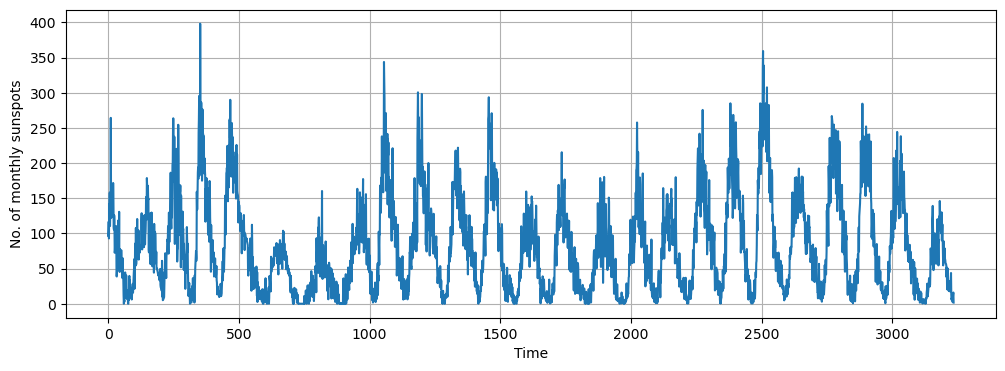

In [2]:
series = df['Monthly Mean Total Sunspot Number'].values
time = range(series.size)
print(series.size)

plt.figure(figsize=(12, 4))
plt.plot(time, series)
plt.xlabel("Time")
plt.ylabel("No. of monthly sunspots")
plt.grid(True)

- 시간 절약을 위해 최근 1000 개월치 data 만 이용

In [3]:
time = df.iloc[-1000:, 0].values
time_series = df.iloc[-1000:, 1].values
time.shape, time_series.shape

((1000,), (1000,))

### windowed dataset 생성

1. series를 이용해 tf.data.Dataset.from_tensor_slices로 데이터셋을 생성합니다.  
2. ds.window를 사용하여 입력 데이터셋을 지정한 윈도우 크기와 함께 슬라이딩 윈도우 방식으로 나눕니다.   drop_remainder=True는 윈도우 크기보다 작은 마지막 윈도우를 제거합니다.  
3. ds.flat_map을 사용하여 각 윈도우를 하나의 배치로 펼칩니다.  
4. ds.shuffle을 사용하여 데이터셋을 무작위로 섞습니다. 이렇게 하면 모델이 훈련 데이터의 순서를 기억하는 것을 방지할 수 있습니다.  
5. ds.map에서 입력 데이터의 마지막 원소를 제외한 부분을 X로 사용하고, 첫 원소를 제외한 부분을 y로 사용하여 다중 스텝 출력을 준비합니다.  
6. 마지막으로, ds.batch를 사용하여 지정된 배치 크기로 데이터를 나누고, ds.prefetch를 사용하여 효율적인 학습을 위해 데이터를 미리 가져옵니다.

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[1:]))  # multi-step output
    ds = ds.batch(batch_size).prefetch(1)
    return ds

#### Forecast Helper Function

- training 후 series data를 model 입력 사양에 맞추어 예측하기 위해 사용 (batch, shuffle 제외)  
- 지도학습 label 불필요하므로 window size 에 +1 을 해줄 필요 없습니다.

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### train/validation set 분리

In [6]:
split_time = 700

time_train = time[:split_time]
time_test = time[split_time:]

X_train = time_series[:split_time]
X_test  = time_series[split_time:]

len(time_train), len(time_test), len(X_train), len(X_test)

(700, 300, 700, 300)

In [8]:
window_size = 132  #132, 64, 30
batch_size = 64
shuffle_buffer_size = 1000

train_ds = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

## Conv1D + LSTM + Bidirectional

- Causal Convolution(인과관계 컨벌루션)은 시간 t의 출력이 시간 t - 1의 입력에서만 파생되도록 합니다.

- Causal padding 은 `Conv1D`에만 지원됩니다.

<img src="https://user-images.githubusercontent.com/24662250/29258799-9b3ff514-80f7-11e7-83e4-ab701fdc2720.png" width=500 />

Causal Convolution(인과 관계 컨벌루션)은 시계열 데이터를 처리할 때 사용되는 기법입니다. 시간 t의 출력이 시간 t 이전의 데이터로만 생성되기 때문에 인과 관계를 유지할 수 있습니다. 이 방법은 미래 데이터를 참조하지 않고 현재 및 과거 데이터만 사용하여 미래를 예측할 수 있게 합니다.

Causal padding은 인과 관계 컨벌루션을 구현하기 위한 패딩 기법입니다. 일반적인 컨벌루션과 달리, causal padding은 입력의 오른쪽 끝(또는 시계열 데이터의 미래 부분)에는 패딩을 추가하지 않고 입력의 왼쪽 끝(또는 시계열 데이터의 과거 부분)에만 패딩을 추가합니다. 이로 인해 컨볼루션 필터는 현재 및 과거 값에만 접근할 수 있으며, 미래 데이터는 참조하지 않게 됩니다.

TensorFlow에서는 Conv1D 레이어를 사용하여 인과 관계 컨벌루션을 구현할 수 있습니다. 이를 위해 padding='causal' 인자를 사용하면 됩니다.

In [9]:
def model_define(kernel_size, lambda_scale):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=kernel_size, strides=1, padding="causal", 
                             activation="relu", input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * lambda_scale)
    ])
    return model

- 초기 epoch 100 동안 learning rate를 변경해 가며 loss가  증가하지 않는 가장 큰 learning rate 를 찾아냅니다.

In [10]:
model = model_define(kernel_size=5, lambda_scale=250)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_ds, epochs=100, verbose=1, callbacks=[lr_schedule])

Epoch 1/100
9/9 [==============================] - 5s 166ms/step - loss: 89.4831 - mae: 89.9815 - lr: 1.0000e-08
Epoch 2/100
9/9 [==============================] - 1s 72ms/step - loss: 86.2023 - mae: 86.7007 - lr: 1.1220e-08
Epoch 3/100
9/9 [==============================] - 1s 70ms/step - loss: 81.4781 - mae: 81.9764 - lr: 1.2589e-08
Epoch 4/100
9/9 [==============================] - 1s 70ms/step - loss: 76.4273 - mae: 76.9250 - lr: 1.4125e-08
Epoch 5/100
9/9 [==============================] - 1s 72ms/step - loss: 71.6275 - mae: 72.1254 - lr: 1.5849e-08
Epoch 6/100
9/9 [==============================] - 1s 72ms/step - loss: 67.2849 - mae: 67.7817 - lr: 1.7783e-08
Epoch 7/100
9/9 [==============================] - 1s 73ms/step - loss: 63.6745 - mae: 64.1719 - lr: 1.9953e-08
Epoch 8/100
9/9 [==============================] - 1s 74ms/step - loss: 60.6304 - mae: 61.1269 - lr: 2.2387e-08
Epoch 9/100
9/9 [==============================] - 1s 73ms/step - loss: 58.0574 - mae: 58.5533 - lr: 2.

9/9 [==============================] - 1s 79ms/step - loss: 22.6478 - mae: 23.1432 - lr: 3.9811e-05
Epoch 74/100
9/9 [==============================] - 1s 76ms/step - loss: 21.8777 - mae: 22.3719 - lr: 4.4668e-05
Epoch 75/100
9/9 [==============================] - 1s 79ms/step - loss: 20.2118 - mae: 20.7054 - lr: 5.0119e-05
Epoch 76/100
9/9 [==============================] - 1s 78ms/step - loss: 24.2123 - mae: 24.7077 - lr: 5.6234e-05
Epoch 77/100
9/9 [==============================] - 1s 79ms/step - loss: 20.7132 - mae: 21.2073 - lr: 6.3096e-05
Epoch 78/100
9/9 [==============================] - 1s 80ms/step - loss: 18.4839 - mae: 18.9772 - lr: 7.0795e-05
Epoch 79/100
9/9 [==============================] - 1s 81ms/step - loss: 37.9561 - mae: 38.4527 - lr: 7.9433e-05
Epoch 80/100
9/9 [==============================] - 1s 80ms/step - loss: 58.0240 - mae: 58.5221 - lr: 8.9125e-05
Epoch 81/100
9/9 [==============================] - 1s 80ms/step - loss: 61.7671 - mae: 62.2658 - lr: 1.0000e

- 안정적 상태에서 최소 mae 를 얻은 learning rate 선택

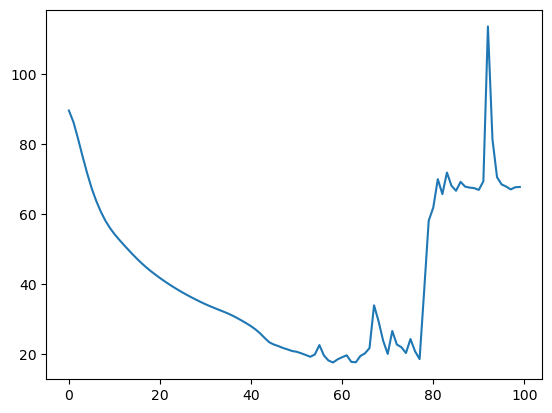

In [11]:
plt.plot(history.history["loss"])

(1e-07, 0.0001, 12.0, 30.0)

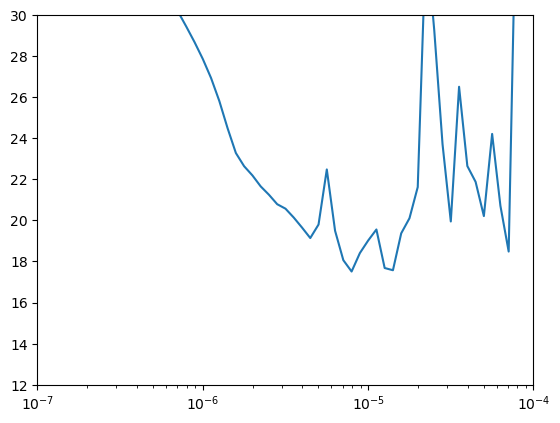

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 12, 30])

이 코드에서 idx는 주어진 history.history["loss"] 리스트에서 최소 손실 값의 위치를 찾아 리스트 형태로 반환합니다. 리스트에는 최소 손실 값에 해당하는 위치가 True로 표시되고 나머지 위치는 False로 표시됩니다.

In [13]:
idx = list(np.array(history.history["loss"]) == np.min(history.history["loss"]))

In [14]:
best_lr = np.array(tuple(history.history['lr']))[idx]
best_lr

array([7.943282e-06], dtype=float32)

### Hyper Parameter Tuning

- optimal learning rate로 충분한 epoch train   
    - optimal lr <-- best_lr  
    - epochs <-- 500

- kernel size를 3으로 조정

- Lambda layer 를 `x * 200`으로 조정

In [15]:
tf.keras.backend.clear_session()
EPOCHS = 300

train_set = windowed_dataset(X_train, window_size, 
                    batch_size, shuffle_buffer_size)

model = model_define(kernel_size=3, lambda_scale=200)

optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr[0], momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=EPOCHS, verbose=1)

Epoch 1/300
9/9 [==============================] - 4s 69ms/step - loss: 41.6495 - mae: 42.1462
Epoch 2/300
9/9 [==============================] - 1s 66ms/step - loss: 27.5484 - mae: 28.0437
Epoch 3/300
9/9 [==============================] - 1s 65ms/step - loss: 24.0056 - mae: 24.5003
Epoch 4/300
9/9 [==============================] - 1s 66ms/step - loss: 27.4767 - mae: 27.9722
Epoch 5/300
9/9 [==============================] - 1s 65ms/step - loss: 24.8422 - mae: 25.3372
Epoch 6/300
9/9 [==============================] - 1s 70ms/step - loss: 21.7320 - mae: 22.2258
Epoch 7/300
9/9 [==============================] - 1s 79ms/step - loss: 19.2439 - mae: 19.7362
Epoch 8/300
9/9 [==============================] - 1s 76ms/step - loss: 17.7424 - mae: 18.2346
Epoch 9/300
9/9 [==============================] - 1s 78ms/step - loss: 17.0819 - mae: 17.5732
Epoch 10/300
9/9 [==============================] - 1s 79ms/step - loss: 16.4612 - mae: 16.9528
Epoch 11/300
9/9 [==============================]

9/9 [==============================] - 1s 77ms/step - loss: 12.2540 - mae: 12.7420
Epoch 87/300
9/9 [==============================] - 1s 76ms/step - loss: 12.4706 - mae: 12.9588
Epoch 88/300
9/9 [==============================] - 1s 76ms/step - loss: 11.7690 - mae: 12.2569
Epoch 89/300
9/9 [==============================] - 1s 78ms/step - loss: 11.3991 - mae: 11.8862
Epoch 90/300
9/9 [==============================] - 1s 78ms/step - loss: 11.3063 - mae: 11.7929
Epoch 91/300
9/9 [==============================] - 1s 78ms/step - loss: 11.1846 - mae: 11.6719
Epoch 92/300
9/9 [==============================] - 1s 77ms/step - loss: 11.7070 - mae: 12.1947
Epoch 93/300
9/9 [==============================] - 1s 76ms/step - loss: 11.3976 - mae: 11.8844
Epoch 94/300
9/9 [==============================] - 1s 79ms/step - loss: 11.3938 - mae: 11.8805
Epoch 95/300
9/9 [==============================] - 1s 79ms/step - loss: 11.0634 - mae: 11.5504
Epoch 96/300
9/9 [==============================] - 1

9/9 [==============================] - 1s 77ms/step - loss: 8.6684 - mae: 9.1527
Epoch 172/300
9/9 [==============================] - 1s 77ms/step - loss: 8.7930 - mae: 9.2774
Epoch 173/300
9/9 [==============================] - 1s 77ms/step - loss: 8.2574 - mae: 8.7399
Epoch 174/300
9/9 [==============================] - 1s 79ms/step - loss: 8.9176 - mae: 9.4023
Epoch 175/300
9/9 [==============================] - 1s 77ms/step - loss: 8.8028 - mae: 9.2876
Epoch 176/300
9/9 [==============================] - 1s 77ms/step - loss: 8.4755 - mae: 8.9596
Epoch 177/300
9/9 [==============================] - 1s 78ms/step - loss: 8.2023 - mae: 8.6852
Epoch 178/300
9/9 [==============================] - 1s 76ms/step - loss: 7.9699 - mae: 8.4523
Epoch 179/300
9/9 [==============================] - 1s 77ms/step - loss: 7.9868 - mae: 8.4686
Epoch 180/300
9/9 [==============================] - 1s 78ms/step - loss: 8.1634 - mae: 8.6459
Epoch 181/300
9/9 [==============================] - 1s 77ms/ste

9/9 [==============================] - 1s 77ms/step - loss: 5.6664 - mae: 6.1425
Epoch 258/300
9/9 [==============================] - 1s 78ms/step - loss: 5.7103 - mae: 6.1870
Epoch 259/300
9/9 [==============================] - 1s 77ms/step - loss: 5.8495 - mae: 6.3259
Epoch 260/300
9/9 [==============================] - 1s 77ms/step - loss: 5.9823 - mae: 6.4616
Epoch 261/300
9/9 [==============================] - 1s 77ms/step - loss: 5.2511 - mae: 5.7249
Epoch 262/300
9/9 [==============================] - 1s 79ms/step - loss: 6.2708 - mae: 6.7507
Epoch 263/300
9/9 [==============================] - 1s 77ms/step - loss: 5.6600 - mae: 6.1359
Epoch 264/300
9/9 [==============================] - 1s 78ms/step - loss: 5.5924 - mae: 6.0674
Epoch 265/300
9/9 [==============================] - 1s 77ms/step - loss: 6.1207 - mae: 6.5996
Epoch 266/300
9/9 [==============================] - 1s 79ms/step - loss: 5.9491 - mae: 6.4269
Epoch 267/300
9/9 [==============================] - 1s 78ms/ste

훈련 과정에서 계산된 평균 절대 오차(MAE)와 손실 값(Loss)을 시각화 합니다.

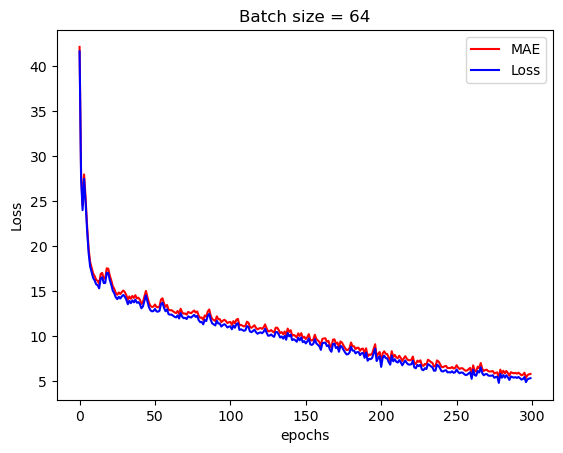

In [16]:
mae=history.history['mae']
loss=history.history['loss']

plt.plot(mae, 'r', label='MAE')
plt.plot(loss, 'b', label='Loss')
plt.title('Batch size = {}'.format(batch_size))
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

In [18]:
print(time_series.shape)
print(X_test.shape)

(1000,)
(300,)


X_test data 를 이용하여 forecast

In [19]:
forecast = model_forecast(model, X_test, window_size)
forecast.shape

169/169 [==============================] - 3s 9ms/step


(169, 132, 1)

In [20]:
forecast = forecast[:, -1, 0]
forecast.shape

(169,)

### True value와 prediction value 비교 시각화

X_test(실제 값)와 forecast(예측 값)을 시계열 데이터로 시각화하는 코드입니다.

plt.plot() 함수를 사용하여 time_test와 X_test(실제 값)를 그래프로 그리고, 범례 레이블을 'True'로 설정합니다.  
plt.plot() 함수를 사용하여 time_test의 끝부분에서 예측된 값의 길이만큼과 forecast(예측 값)를 그래프로 그리고, 범례 레이블을 'Forecast'로 설정합니다.  

초반 window_size 만큼의 데이터는 예측 과정에서 skip되므로, 그래프에서도 그 부분이 생략되어 그려집니다.

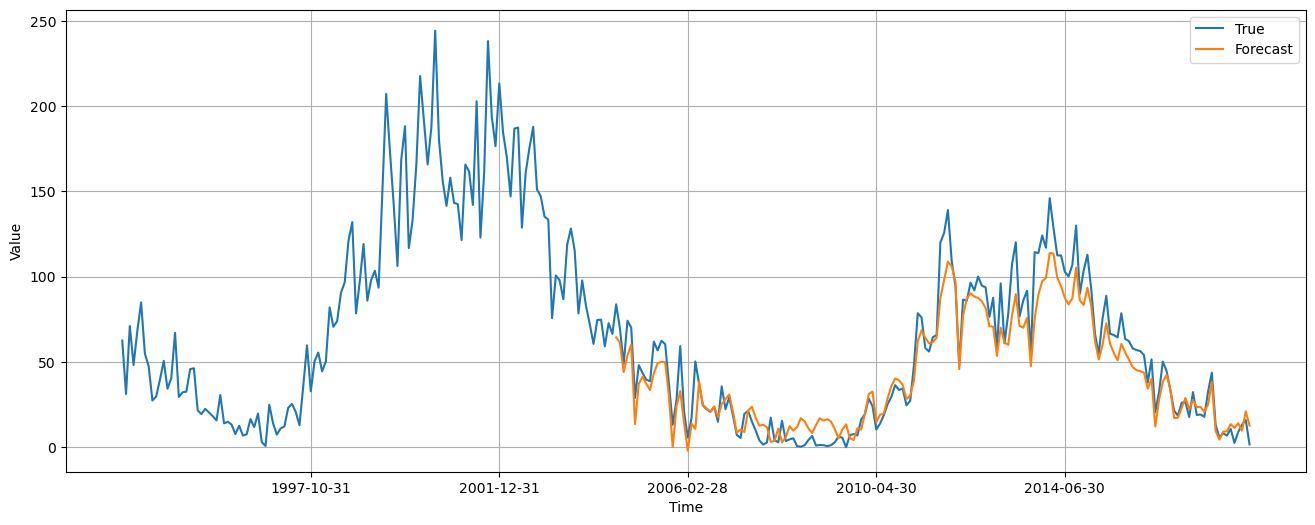

In [21]:
plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test, label='True')
plt.plot(time_test[-len(forecast):] , forecast, label='Forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.xticks([50, 100, 150, 200, 250])
plt.grid(True)
plt.legend()

X_test와 forecast 간의 평균 제곱 오차(mean squared error, MSE)와 평균 절대 오차(mean absolute error, MAE)를 계산하고 출력합니다.

In [22]:
print(tf.keras.metrics.mean_squared_error(X_test[window_size-1:], forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test[window_size-1:], forecast).numpy())

152.2272
9.36597


## Window Size를 바꾸어 가며 Tuning

11 년 주기의 noise 가 심한 data 이므로 다양한 size 의 window 를 try 하며 model tuning --> 132, 30, 64 등